## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

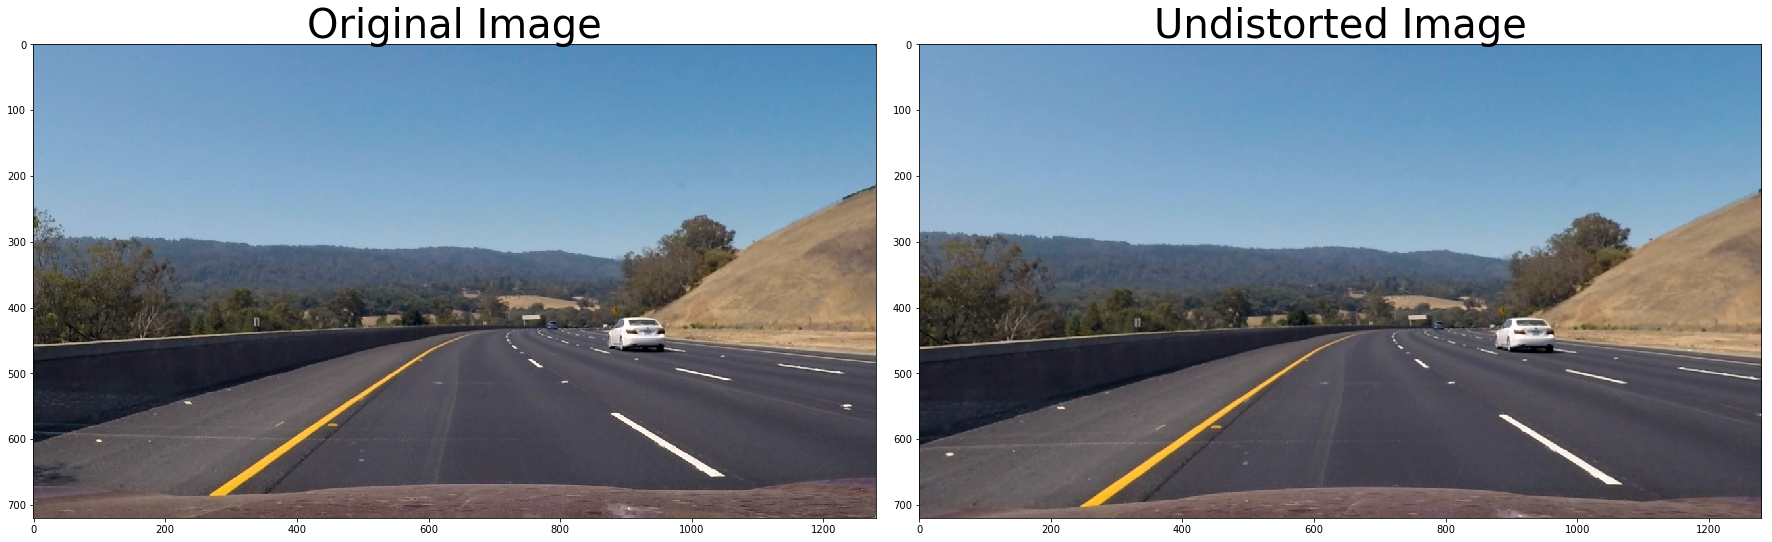

In [2]:
import matplotlib.image as mpimg
test_img = mpimg.imread('./test_images/test3.jpg')

undist = cv2.undistort(test_img, mtx, dist, None, mtx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('./output_images/undistorted_test3.png')

In [3]:
def color_gradient_threshold(img, thresh_type = 0, sx_thresh=(20, 200), 
                                                   hls_s_thresh=(180, 255), 
                                                   hls_l_thresh=(225,255),
                                                   lab_b_thresh=(180,250)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
    hls_s_channel = hls[:,:,2]
    hls_l_channel = hls[:,:,1]
    lab_b_channel = lab[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    hls_s_binary = np.zeros_like(hls_s_channel)
    hls_s_binary[(hls_s_channel >= hls_s_thresh[0]) & (hls_s_channel <= hls_s_thresh[1])] = 1
    
    hls_l_binary = np.zeros_like(hls_l_channel)
    hls_l_binary[(hls_l_channel >= hls_l_thresh[0]) & (hls_l_channel <= hls_l_thresh[1])] = 1
    
    # Threshold color channel
    lab_b_binary = np.zeros_like(lab_b_channel)
    lab_b_binary[(hls_s_channel >= lab_b_thresh[0]) & (lab_b_channel <= lab_b_thresh[1])] = 1
    
    if thresh_type == 0:
       # Stack each channel to view their individual contributions in green and blue respectively
       # This returns a stack of the two binary images, whose components you can see as different colors
       color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, hls_s_binary)) * 255

       # Combine the two binary thresholds
       combined_binary = np.zeros_like(sxbinary)
       combined_binary[(hls_s_binary == 1) | (sxbinary == 1)] = 1
    else:
       # Stack each channel to view their individual contributions in green and blue respectively
       # This returns a stack of the two binary images, whose components you can see as different colors
       color_binary = np.dstack(( np.zeros_like(sxbinary), lab_b_binary, hls_l_binary)) * 255

       # Combine the two binary thresholds
       combined_binary = np.zeros_like(lab_b_binary)
       combined_binary[(hls_l_binary == 1) | (lab_b_binary == 1)] = 1
    
    return combined_binary, color_binary


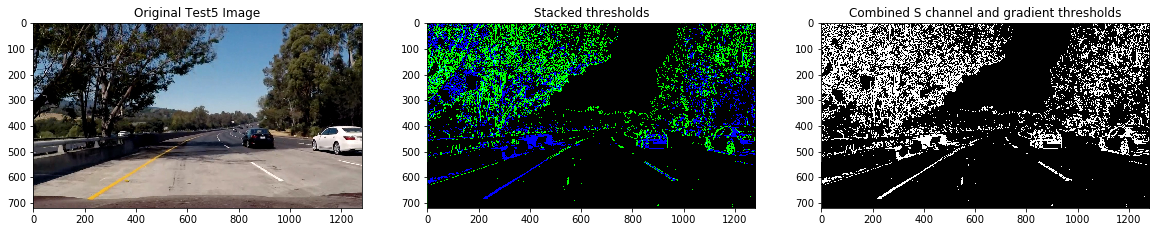

In [4]:
import matplotlib.image as mpimg
test_img = mpimg.imread('./test_images/test5.jpg')

combined_binary,colored_binary = color_gradient_threshold(test_img, 0)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.set_title('Original Test5 Image')
ax1.imshow(test_img)

ax2.set_title('Stacked thresholds')
ax2.imshow(colored_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')
plt.show()
f.savefig('./output_images/binary_combo_test5.jpg')

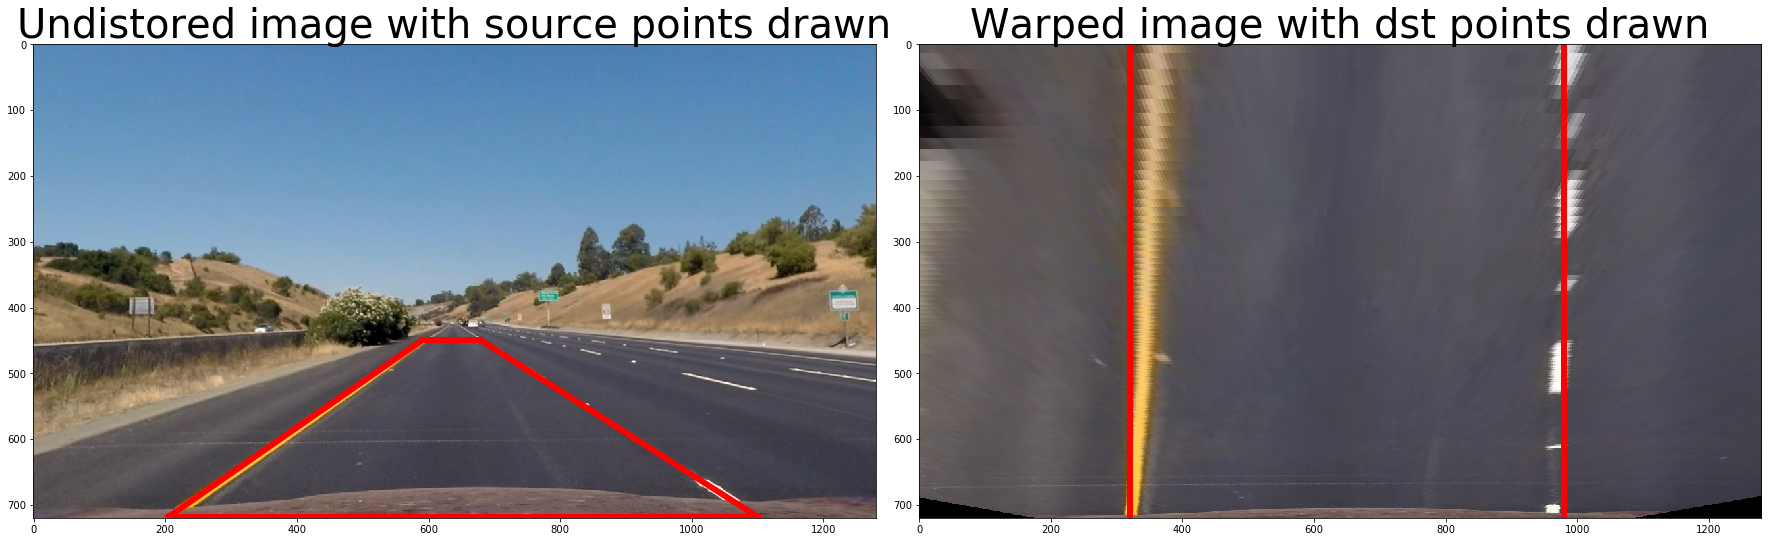

In [6]:
percep_trans_cal_img = mpimg.imread('./test_images/straight_lines1.jpg')
undist_percep_trans_cal_img = cv2.undistort(percep_trans_cal_img, mtx, dist, None, mtx)

src = np.float32([[205,719],
                [590,450],
                [680,450],
                [1100,719]])

dst = np.float32([[320, 719],
                [320, 0],
                [960, 0],
                [960, 719]])

def find_M_Minv(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

M, Minv = find_M_Minv(undist_percep_trans_cal_img, src, dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

warped_testimg = cv2.warpPerspective(undist_percep_trans_cal_img, M, (1280, 720), flags=cv2.INTER_NEAREST)

ax1.imshow(undist_percep_trans_cal_img)
ax1.set_title('Undistored image with source points drawn', fontsize=40)
ax1.plot((205,1100),(718,718),'r',linewidth = 6)
ax1.plot((680,1100),(450,718),'r',linewidth = 6)
ax1.plot((680,590),(450,450),'r',linewidth = 6)
ax1.plot((590,205),(450,718),'r',linewidth = 6)

ax2.imshow(warped_testimg, cmap='gray')
ax2.plot((320,320),(0,img.shape[0]-1),'r', linewidth = 6)
ax2.plot((980,980),(0,img.shape[0]-1),'r', linewidth = 6)
ax2.set_title('Warped image with dst points drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('./output_images/warped_straight_lines.jpg')

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

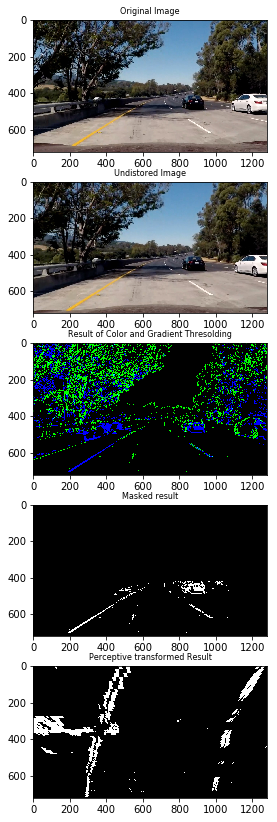

In [8]:
def warper(img, mtx, dist, M, display):
    
    # 1. correct distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2. apply color and gradient threshold to identify potential lane lines
    result,colored = color_gradient_threshold(undist)

    # 3. focusing on the area of interest
    vertices = np.array([[(img.shape[1]/9, img.shape[0]), 
                          (img.shape[1]/2-100, img.shape[0]/2+60), 
                          (img.shape[1]/2+400, img.shape[0]/2+60), 
                          (img.shape[1], img.shape[0])]], dtype=np.int32)
                           
    masked_result = region_of_interest(result, vertices)
    
    # 4. apply perspective transform
    warped = cv2.warpPerspective(masked_result, M, (result.shape[1], result.shape[0]), flags=cv2.INTER_NEAREST)

    # 5. result visualization
    if display == 1:
        
       f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(32, 12))
       f.tight_layout()

       ax1.imshow(img)
       ax1.set_title('Original Image', fontsize=8)
       ax2.imshow(undist)
       ax2.set_title('Undistored Image', fontsize=8)
       ax3.imshow(colored, cmap='gray')
       ax3.set_title('Result of Color and Gradient Thresolding', fontsize=8)
       ax4.imshow(masked_result, cmap='gray')
       ax4.set_title('Masked result', fontsize=8)
       ax5.imshow(warped, cmap='gray')
       ax5.set_title('Perceptive transformed Result', fontsize=8)

       plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
       plt.show()
    
    return warped, undist

# test warper
img = mpimg.imread('./test_images/test5.jpg')
warped_img, undist = warper(img, mtx, dist, M, 1)

In [9]:
def fit_left_right_curves(warped, display):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
       # Identify window boundaries in x and y (and right and left)
       win_y_low = warped.shape[0] - (window+1)*window_height
       win_y_high = warped.shape[0] - window*window_height
       win_xleft_low = leftx_current - margin
       win_xleft_high = leftx_current + margin
       win_xright_low = rightx_current - margin
       win_xright_high = rightx_current + margin
       # Draw the windows on the visualization image
       cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
       (0,255,0), 2) 
       cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
       (0,255,0), 2) 
       # Identify the nonzero pixels in x and y within the window
       good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
       (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
       good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
       (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
       # Append these indices to the lists
       left_lane_inds.append(good_left_inds)
       right_lane_inds.append(good_right_inds)
       # If you found > minpix pixels, recenter next window on their mean position
       if len(good_left_inds) > minpix:
          leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
       if len(good_right_inds) > minpix:        
          rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if len(leftx) > 0 and len(rightx) > 0:
       # Fit a second order polynomial to each
       left_fit = np.polyfit(lefty, leftx, 2)
       right_fit = np.polyfit(righty, rightx, 2)
    
       ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
       left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
       right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        left_fit = None
        right_fit = None
        
    if display == 1:
       f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
       f.tight_layout()
        
       out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
       out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
       ax1.imshow(out_img)
       ax1.plot(left_fitx, ploty, color='yellow')
       ax1.plot(right_fitx, ploty, color='yellow')
       #ax1.xlim(0, 1280)
       #ax1.ylim(720, 0)
       ax1.set_title('Image 1', fontsize=8)
       
       # Create an image to draw on and an image to show the selection window
       out_img = np.dstack((warped, warped, warped))*255
       window_img = np.zeros_like(out_img)
       # Color in left and right line pixels
       out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
       out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

       # Generate a polygon to illustrate the search window area
       # And recast the x and y points into usable format for cv2.fillPoly()
       left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
       left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
       left_line_pts = np.hstack((left_line_window1, left_line_window2))
       right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
       right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
       right_line_pts = np.hstack((right_line_window1, right_line_window2))

       # Draw the lane onto the warped blank image
       cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
       cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
       result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
       ax2.imshow(result)
       ax2.plot(left_fitx, ploty, color='yellow')
       ax2.plot(right_fitx, ploty, color='yellow')
       #ax2.xlim(0, 1280)
       #ax2.ylim(720, 0)
       ax2.set_title('Image 2', fontsize=8)

       plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
       plt.show() 
       f.savefig('./output_images/color_fit_lines.jpg')
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

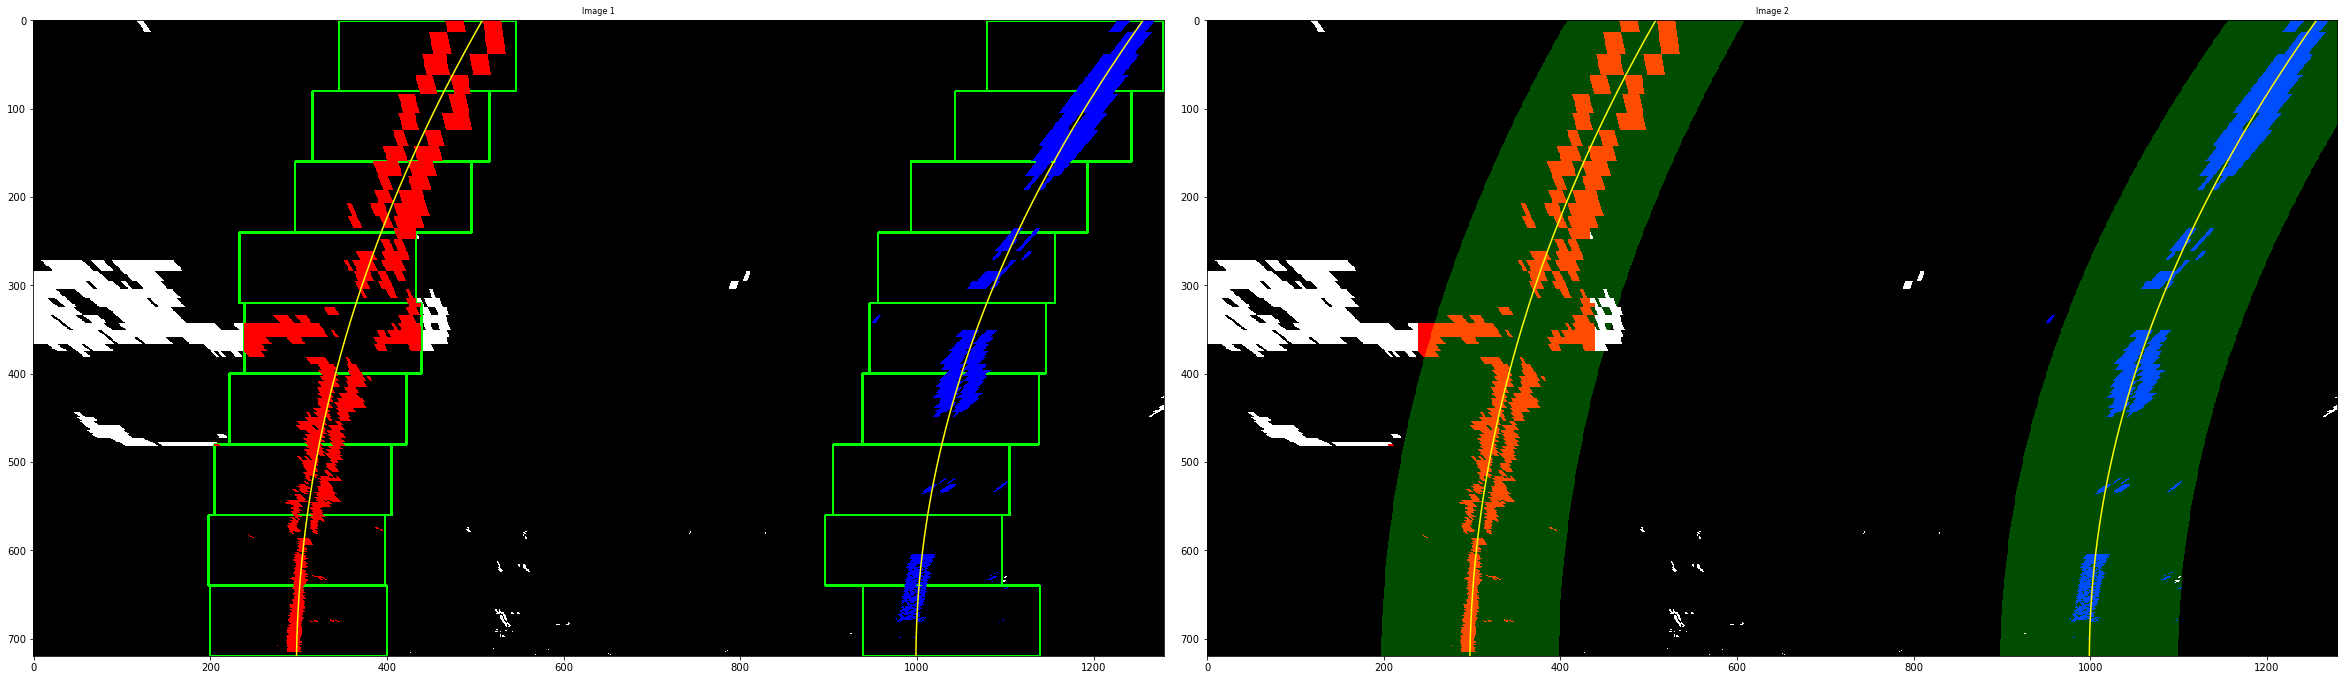

In [10]:
# curve fitting of both left and right lanes
left_fit, right_fit, leftx, lefty, rightx, righty = fit_left_right_curves(warped_img, 1)

In [11]:
def fit_without_slidingwindow_search(warped, prev_left_fit, prev_right_fit):
     # Assume you now have a new warped binary image 
     # from the next frame of video (also called "binary_warped")
     # It's now much easier to find line pixels!
     nonzero = warped.nonzero()
     nonzeroy = np.array(nonzero[0])
     nonzerox = np.array(nonzero[1])
     margin = 100
     left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                       prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                       prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 

     right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                       prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                       prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

     
     # Again, extract left and right line pixel positions
     leftx = nonzerox[left_lane_inds]
     lefty = nonzeroy[left_lane_inds] 
     rightx = nonzerox[right_lane_inds]
     righty = nonzeroy[right_lane_inds]
     
     # Fit a second order polynomial to each
     if len(leftx > 0):
        left_fit = np.polyfit(lefty, leftx, 2)
     else:
        left_fit = None
     if len(rightx > 0):
        right_fit = np.polyfit(righty, rightx, 2)
     else:
        right_fit = None
     
     return left_fit, right_fit, leftx, lefty, rightx, righty


In [12]:
def calculate_curverad(leftx, lefty, rightx, righty, warped_img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(warped_img.shape[0])
    
    # Fit polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad




In [13]:
left_curverad, right_curverad = calculate_curverad(leftx, lefty, rightx, righty, warped_img)
print(left_curverad, 'm', right_curverad, 'm')

426.535652628 m 335.682571216 m


In [14]:
def draw_lines_on_original_image(left_fit, right_fit, undist, left_curverad, right_curverad, warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    leftx_bot = left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2]
    rightx_bot = right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2]
    
    lane_center = (rightx_bot + leftx_bot)/2
    distance_from_center = abs((640 - lane_center)*3.7/700) 
    
    if lane_center > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,0), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,0), thickness = 2)
    
    # Print radius of curvature on image
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,0), thickness = 2)

    return result
 

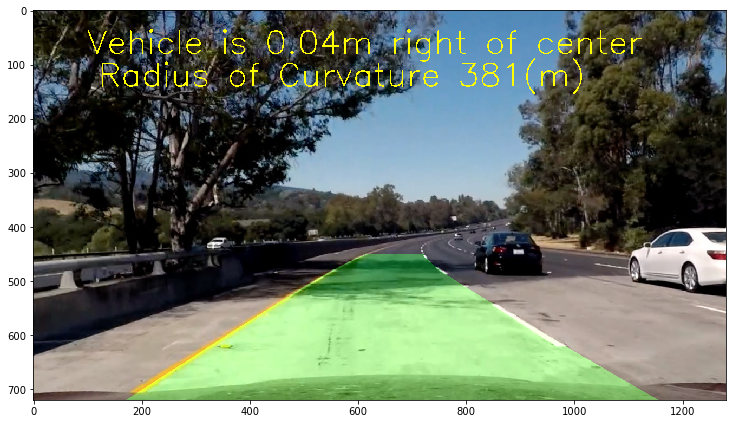

In [15]:
result = draw_lines_on_original_image(left_fit, right_fit, undist, left_curverad, right_curverad, warped_img)
f, ax = plt.subplots(1, 1, figsize=(16, 6))
f.tight_layout()   
ax.imshow(result)
plt.show()
f.savefig('./output_images/example_output.jpg')

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def get_intercepts(polynomial, height):
    bottom = polynomial[0]*height**2 + polynomial[1]*height + polynomial[2]
    top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
    return bottom

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        # how many recent fits to be keeped
        self.max_saved_fits = 8
        # record home many frames processed
        self.framecount = 0
     
    def update(self, fit, x, y):
        self.framecount = self.framecount + 1
        if fit is not None:
            if self.best_fit is not None:
               self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.002 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
               self.detected = False
            else:
               self.detected = True
               self.current_fit.append(fit)
               if len(self.current_fit) > self.max_saved_fits:
                  # add current high confident fit at the end of array
                  self.current_fit = self.current_fit[len(self.current_fit)-self.max_saved_fits:]
               self.best_fit = np.average(self.current_fit, axis = 0)
        else:
            self.detected = False;
            if len(self.current_fit) > 0:
                # purge oldest fit, but do not add any new entry for current fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
     
    def calculate_curverad(self, x, y):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        y_eval = 720
    
        # Fit polynomials to x,y in world space
        if len(x) > 0:
           fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
           # Calculate the new radii of curvature
           self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
def process_image(image):
    
    img = np.copy(image)
    warped_img, undist = warper(img, mtx, dist, M, 0)
    
    # use sliding window search for lines if there is lane marked undetected
    if not left_line.detected or not right_line.detected:
        l_fit, r_fit, lx, ly, rx, ry = fit_left_right_curves(warped_img, 0)
    else: # search from last known good fits
        l_fit, r_fit, lx, ly, rx, ry = fit_without_slidingwindow_search(warped_img, left_line.best_fit, right_line.best_fit)

    #sanity check on detected road width
    if l_fit is not None and r_fit is not None:
        l_fit_x_intercept = get_intercepts(l_fit, img.shape[0])
        r_fit_x_intercept = get_intercepts(r_fit, img.shape[0])
        
        lane_width = abs(l_fit_x_intercept-r_fit_x_intercept)
        if lane_width > 900 or lane_width < 200:
            l_fit = None
            r_fit = None
            
    left_line.update(l_fit, lx, ly)
    right_line.update(r_fit, rx, ry)
    
    if (left_line.framecount-1) % 4 == 0:
       left_line.calculate_curverad(lx, ly)
       right_line.calculate_curverad(rx, ry)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        result = draw_lines_on_original_image(left_line.best_fit, right_line.best_fit, undist, left_line.radius_of_curvature, right_line.radius_of_curvature, warped_img)
    else:
        result = img
    
    return result

In [19]:
left_line = Line()
right_line = Line()
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  7.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 14s, sys: 37.6 s, total: 4min 51s
Wall time: 2min 40s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [21]:
left_line = Line()
right_line = Line()
white_output = 'harder_challenge_video_output.mp4'
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,8.03)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:52<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 19s, sys: 38.7 s, total: 4min 58s
Wall time: 2min 53s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))